<a href="https://colab.research.google.com/github/marcellinus-witarsah/speech-to-text-model/blob/main/speech_to_text_models/train_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps
1. Import data
2. Data Preprocessing: convert data into a `spectogram`
3. Data Splitting: split data into train, dev, and test sets
4. Create Model
5. Train Model
6. Evaluate Results

## Libraries
1. Librosa: Python package for music and audio analysis

In [1]:
# Libraries
!pip install --upgrade tensorflow tensorflow_datasets
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 7.0 kB/s 
     |████████████████████████████████| 4.7 MB 56.4 MB/s 
     |████████████████████████████████| 6.0 MB 57.5 MB/s 
     |████████████████████████████████| 1.7 MB 49.5 MB/s 
     |████████████████████████████████| 439 kB 71.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import Data

In [5]:
# Using bigger data
ds, ds_info = tfds.load('speech_commands', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteQIUBQC/speech_commands-train.tfrecord*...:…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteQIUBQC/speech_commands-validation.tfrecord…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/0.0.3.incompleteQIUBQC/speech_commands-test.tfrecord*...: …

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


## Check Data

In [70]:
ds_info.features['label'].names

['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'up',
 'yes',
 '_silence_',
 '_unknown_']

In [71]:
commands = np.array(ds_info.features['label'].names)
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'up' 'yes' '_silence_'
 '_unknown_']


## Data Splitting
Using `tf.keras.utils.audio_dataset_from_directory` which do the heavy lifting for us in splitting the data. The output function will be a `tf.data.Dataset` based on the audio files where we can implement parallellization, prefecthing and caching for faster training.

The arguments that we need to provide are:
1. Batch size
2. Validation split
3. Output sequence length: maximum length of audio sequence. If not being set then all audio files will be set to the longest audio sequence and will be zero padded.
4. Subset : subset of data return whether it is 'training', 'validation', and 'both'. 'both' can be run if **validation_split** parameter is set to **True**

In [72]:
ds_train, ds_val, ds_test = ds['train'], ds['validation'], ds['test']
class_names = np.array(ds_info.features['label'].names)
print()
for name, label in zip(class_names, np.array(range(len(class_names)))):
    print("{}: {}".format(name, label))


down: 0
go: 1
left: 2
no: 3
off: 4
on: 5
right: 6
stop: 7
up: 8
yes: 9
_silence_: 10
_unknown_: 11


Since the dataset only contains only a single channels then we can delete the last axis

## Visualize Data

0 tf.Tensor([-15 -18 -12 ...  16  21  25], shape=(16000,), dtype=int16)
1 tf.Tensor([  75   29  -85 ... -343  304  879], shape=(16000,), dtype=int16)
2 tf.Tensor([0 0 2 ... 2 1 1], shape=(16000,), dtype=int16)
3 tf.Tensor([ 1 15 13 ... 29 34 14], shape=(16000,), dtype=int16)
4 tf.Tensor([ 0  0  0 ...  1 -1  2], shape=(16000,), dtype=int16)
5 tf.Tensor([  0   0   0 ... -22 -59 -24], shape=(12456,), dtype=int16)
6 tf.Tensor([  45   82   40 ... -352 -371 -307], shape=(12632,), dtype=int16)
7 tf.Tensor([ 29  87 151 ... 263 222 153], shape=(16000,), dtype=int16)
8 tf.Tensor([-12 -15 -20 ...  10  18   9], shape=(16000,), dtype=int16)


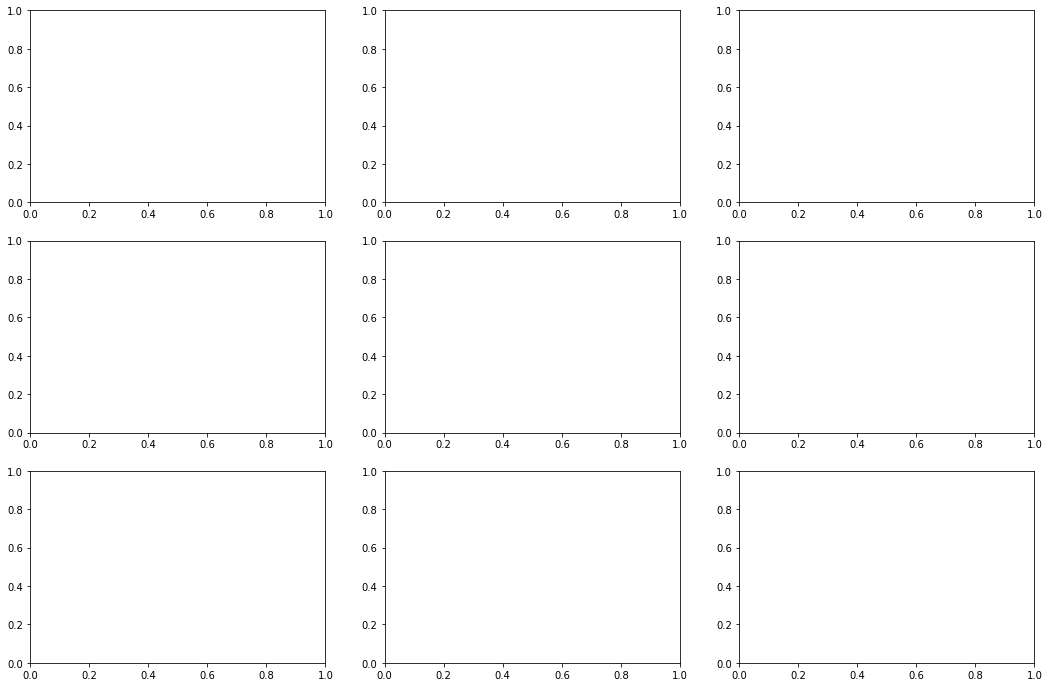

In [78]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

for key, example in enumerate(ds_train.take(9)):
    print(key, example[0])

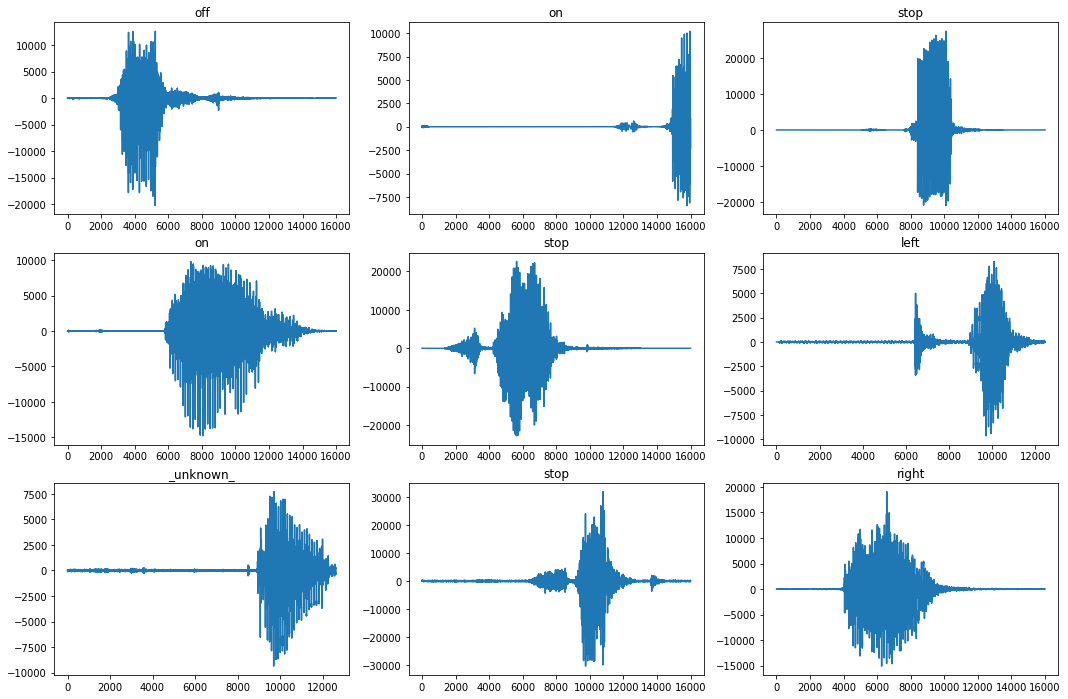

In [81]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

for i, example  in enumerate(ds_train.take(9)):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example[0].numpy())
    # ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = class_names[example[1]]
    ax.set_title(label)
    # ax.set_ylim([-1.1,1.1])

plt.show()

## Data Preprocessing
Converting waveforms to **spectograms** (x-axis=time, y-axis=frequency) using **short-time Fourier transform (STFT)**. **Spectograms** which show frequency changes over time and can be represented as 2D images. This spectogram is what will be feed to the neural network model.

A **Fourier transform** (tf.signal.fft) and **STFT** (tf.signal.stft) both converts a signal to its component **frequencies**. The difference is a **Fourier Transform** loses all time information but the **STFT** (**divide the waveforms into multiple windows of time and runs a Fourier Transform** on it) preserving some time information, and returning a 2D tensor that you can run standard convolutions on.
![image.png](https://github.com/marcellinus-witarsah/speech-to-text-model/blob/main/images/spectogram.png?raw=1)

Create a utility function for converting waveforms to spectograms:
1. The waveforms need to be the same length because we want the same length spectogram. If one of the audio waveform length is shorter than the longest length in the data, then it will be padded by 0 filling the remaining length.
2. When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice.
3. The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [54]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128,
    )
    spectrogram=tf.abs(spectrogram)
    spectrogram=spectrogram[..., tf.newaxis]
    return spectrogram

In [ ]:
for i in range(3):
    label = commands[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Plot spectrogram

In [55]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

NameError: ignored

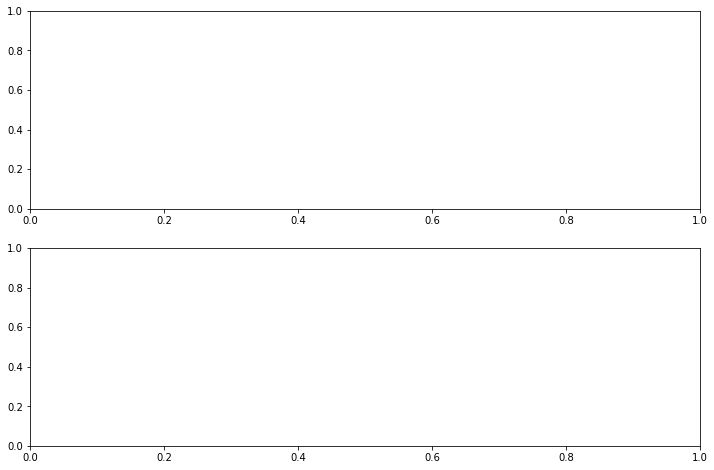

In [56]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Create spectrogram from the audio datasets

In [58]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [59]:
train_spectrogram_ds = make_spec_ds(ds_train)
val_spectrogram_ds = make_spec_ds(ds_val)
test_spectrogram_ds = make_spec_ds(ds_test)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


ValueError: ignored

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

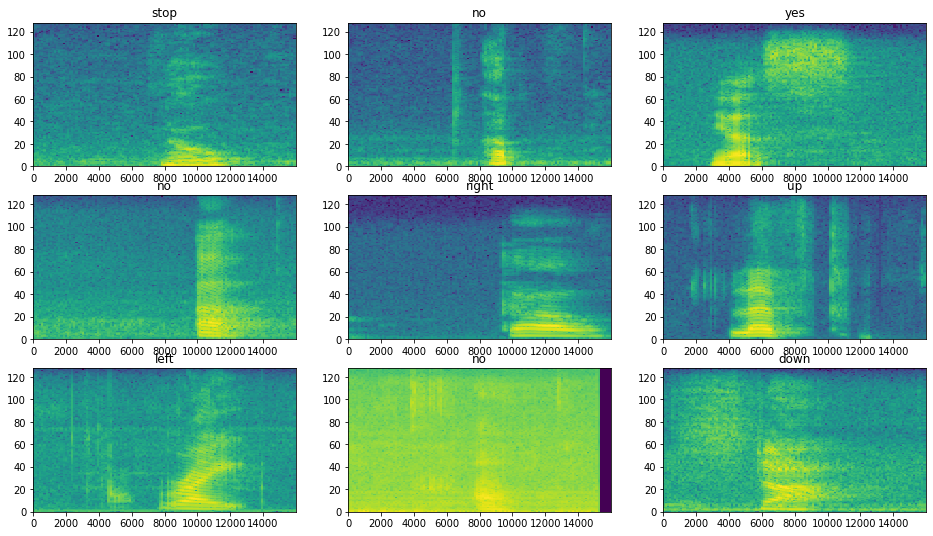

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## Create Model

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Define input shape
input_shape = example_spectrograms.shape[1:]
print("input shape: {}".format(input_shape))
num_labels = len(commands)

# Normalize layer
norm_layer = tf.keras.layers.Normalization()
# Normalizaiton layer according to the data that is available
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))

# CNN Model
def one_cnn_model(input_shape):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # resize
        tf.keras.layers.Resizing(32, 32),
        # normalize
        norm_layer,
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ], name='cnn_model')

def two_cnn_model(input_shape):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # resize
        tf.keras.layers.Resizing(32, 32),
        # normalize
        norm_layer,
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ], name='cnn_model')

input shape: (124, 129, 1)


In [ ]:
model = two_cnn_model(input_shape)
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_7 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_7 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 12544)             0 

In [ ]:
# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 20
CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2,
        verbose=2,
    ),
    tf.keras.callbacks.ModelCheckpoint(
         filepath=model.name, 
         monitor='val_accuracy',
         save_best_only=True,
         mode='max',
         verbose=2,
    ),
]
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

Epoch 1/20
 98/100 [============================>.] - ETA: 0s - loss: 1.7982 - accuracy: 0.3490
Epoch 1: val_accuracy improved from -inf to 0.55990, saving model to cnn_model


100/100 [==============================] - 7s 38ms/step - loss: 1.7949 - accuracy: 0.3498 - val_loss: 1.4046 - val_accuracy: 0.5599
Epoch 2/20
 93/100 [==========================>...] - ETA: 0s - loss: 1.3039 - accuracy: 0.5358
Epoch 2: val_accuracy improved from 0.55990 to 0.66797, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 1.2932 - accuracy: 0.5378 - val_loss: 1.0555 - val_accuracy: 0.6680
Epoch 3/20
 95/100 [===========================>..] - ETA: 0s - loss: 1.0023 - accuracy: 0.6400
Epoch 3: val_accuracy improved from 0.66797 to 0.75000, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 1.0070 - accuracy: 0.6389 - val_loss: 0.8234 - val_accuracy: 0.7500
Epoch 4/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.8569 - accuracy: 0.6977
Epoch 4: val_accuracy improved from 0.75000 to 0.76953, saving model to cnn_model


100/100 [==============================] - 2s 18ms/step - loss: 0.8515 - accuracy: 0.6977 - val_loss: 0.7261 - val_accuracy: 0.7695
Epoch 5/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.7353 - accuracy: 0.7354
Epoch 5: val_accuracy improved from 0.76953 to 0.78776, saving model to cnn_model


100/100 [==============================] - 2s 18ms/step - loss: 0.7369 - accuracy: 0.7356 - val_loss: 0.6942 - val_accuracy: 0.7878
Epoch 6/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.6652 - accuracy: 0.7597
Epoch 6: val_accuracy improved from 0.78776 to 0.80729, saving model to cnn_model


100/100 [==============================] - 2s 21ms/step - loss: 0.6641 - accuracy: 0.7602 - val_loss: 0.6186 - val_accuracy: 0.8073
Epoch 7/20
 97/100 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.7811
Epoch 7: val_accuracy improved from 0.80729 to 0.82161, saving model to cnn_model


100/100 [==============================] - 2s 18ms/step - loss: 0.5957 - accuracy: 0.7833 - val_loss: 0.5620 - val_accuracy: 0.8216
Epoch 8/20
 99/100 [============================>.] - ETA: 0s - loss: 0.5525 - accuracy: 0.8021
Epoch 8: val_accuracy improved from 0.82161 to 0.82422, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 0.5515 - accuracy: 0.8027 - val_loss: 0.5535 - val_accuracy: 0.8242
Epoch 9/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.4898 - accuracy: 0.8261
Epoch 9: val_accuracy improved from 0.82422 to 0.83073, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 0.4910 - accuracy: 0.8247 - val_loss: 0.5186 - val_accuracy: 0.8307
Epoch 10/20
100/100 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.8339
Epoch 10: val_accuracy improved from 0.83073 to 0.83984, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 0.4731 - accuracy: 0.8339 - val_loss: 0.5194 - val_accuracy: 0.8398
Epoch 11/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4309 - accuracy: 0.8485
Epoch 11: val_accuracy improved from 0.83984 to 0.85286, saving model to cnn_model


100/100 [==============================] - 2s 21ms/step - loss: 0.4306 - accuracy: 0.8484 - val_loss: 0.4794 - val_accuracy: 0.8529
Epoch 12/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.4013 - accuracy: 0.8548
Epoch 12: val_accuracy did not improve from 0.85286
100/100 [==============================] - 1s 7ms/step - loss: 0.4024 - accuracy: 0.8541 - val_loss: 0.4718 - val_accuracy: 0.8503
Epoch 13/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.3778 - accuracy: 0.8634
Epoch 13: val_accuracy improved from 0.85286 to 0.86198, saving model to cnn_model


100/100 [==============================] - 2s 18ms/step - loss: 0.3832 - accuracy: 0.8600 - val_loss: 0.4277 - val_accuracy: 0.8620
Epoch 14/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.3762 - accuracy: 0.8700
Epoch 14: val_accuracy did not improve from 0.86198
100/100 [==============================] - 1s 7ms/step - loss: 0.3810 - accuracy: 0.8670 - val_loss: 0.4328 - val_accuracy: 0.8581
Epoch 15/20
 96/100 [===========================>..] - ETA: 0s - loss: 0.3535 - accuracy: 0.8713
Epoch 15: val_accuracy did not improve from 0.86198
100/100 [==============================] - 1s 7ms/step - loss: 0.3512 - accuracy: 0.8723 - val_loss: 0.4164 - val_accuracy: 0.8620
Epoch 16/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.3206 - accuracy: 0.8886
Epoch 16: val_accuracy did not improve from 0.86198
100/100 [==============================] - 1s 7ms/step - loss: 0.3200 - accuracy: 0.8886 - val_loss: 0.4275 - val_accuracy: 0.8620
Epoch 17/20
 94/100 [=======

100/100 [==============================] - 2s 19ms/step - loss: 0.2898 - accuracy: 0.8977 - val_loss: 0.4090 - val_accuracy: 0.8776
Epoch 20/20
 98/100 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.9023
Epoch 20: val_accuracy did not improve from 0.87760
100/100 [==============================] - 1s 8ms/step - loss: 0.2814 - accuracy: 0.9023 - val_loss: 0.4300 - val_accuracy: 0.8594


Plot model training performance

In [ ]:
best_model = tf.keras.models.load_model('cnn_model')

Text(0.5, 1.0, 'cnn_model Accuracy vs Validation Accuracy')

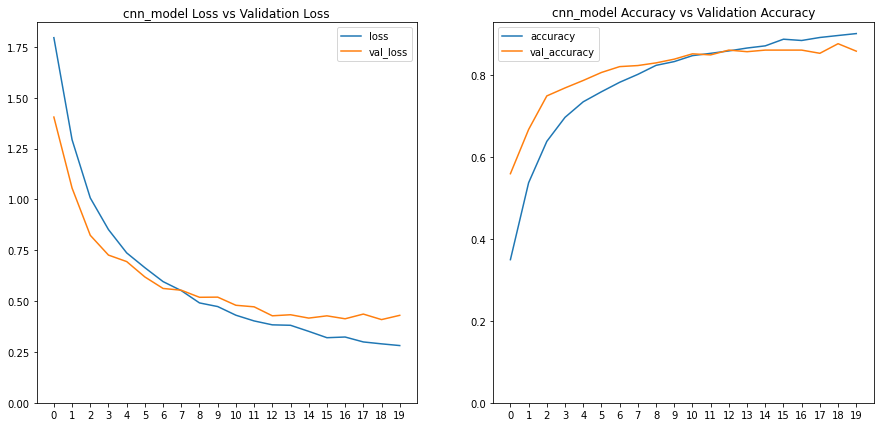

In [ ]:
metrics = history.history
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xticks(history.epoch)
plt.title("{} Loss vs Validation Loss".format(history.model.name))
plt.subplot(1,2,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, max(plt.ylim())])
plt.xticks(history.epoch)
plt.title("{} Accuracy vs Validation Accuracy".format(history.model.name))

Evaluate model

In [ ]:
best_model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 2s 98ms/step - loss: 0.4522 - accuracy: 0.8582


{'loss': 0.45221513509750366, 'accuracy': 0.8581730723381042}

Create a confussion matrix

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spectrogram, label: label)), axis=0)

13/13 [==============================] - 1s 6ms/step


In [ ]:
for i in range(len(class_names)):
    print("{}: {}".format(i, class_names[i])) 
print(classification_report(y_true, y_pred))

0: down
1: go
2: left
3: no
4: right
5: stop
6: up
7: yes
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       109
           1       0.58      0.77      0.66       100
           2       0.96      0.88      0.92       108
           3       0.76      0.74      0.75       105
           4       0.95      0.94      0.95        85
           5       0.98      0.86      0.92       111
           6       0.89      0.91      0.90       103
           7       0.97      0.93      0.95       111

    accuracy                           0.85       832
   macro avg       0.87      0.85      0.86       832
weighted avg       0.87      0.85      0.86       832



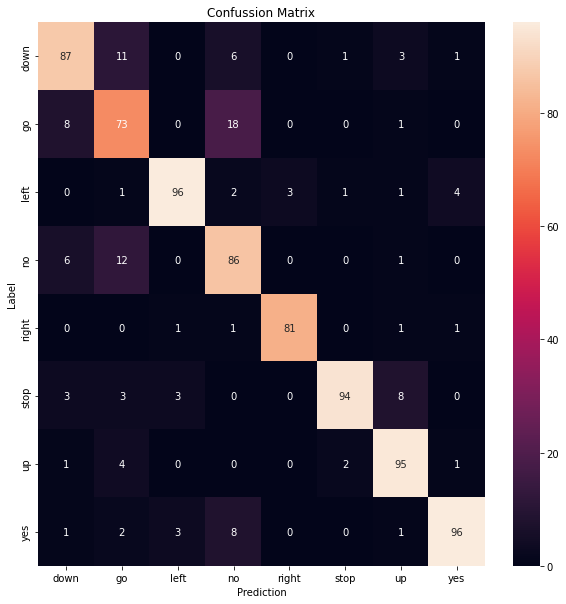

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, 
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confussion Matrix')
plt.show()

tf.Tensor(0.040887598, shape=(), dtype=float32)
tf.Tensor(89.42183, shape=(), dtype=float32)
tf.Tensor(7.0070465e-09, shape=(), dtype=float32)
tf.Tensor(10.537285, shape=(), dtype=float32)
tf.Tensor(3.6166305e-06, shape=(), dtype=float32)
tf.Tensor(1.6562839e-07, shape=(), dtype=float32)
tf.Tensor(1.1208842e-06, shape=(), dtype=float32)
tf.Tensor(3.134999e-10, shape=(), dtype=float32)


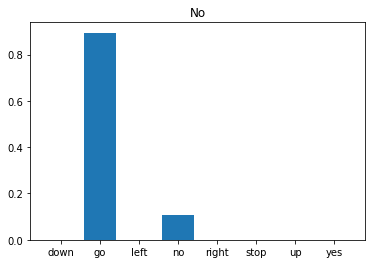

In [ ]:
x = data_dir/'go/0132a06d_nohash_2.wav'

# x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = best_model(x)
for proba in prediction[0]:
    print(proba*100)
plt.bar(class_names, prediction[0])
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
!zip -r ./cnn_model.zip ./cnn_model

  adding: cnn_model/ (stored 0%)
  adding: cnn_model/saved_model.pb (deflated 88%)
  adding: cnn_model/variables/ (stored 0%)
  adding: cnn_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: cnn_model/variables/variables.index (deflated 62%)
  adding: cnn_model/keras_metadata.pb (deflated 90%)
  adding: cnn_model/fingerprint.pb (stored 0%)
  adding: cnn_model/assets/ (stored 0%)
